# Diffusion of a Solution of Nearly-Hard Spheres

## Overview

### Questions

* How do I set up a simulation of of MD particles (solutes) in MPCD particles
  (solvent)?

### Objectives

* Demonstrate how to add MPCD particles to an existing MD particle **Frame**
  or GSD file.
* Show how to couple MD particles to MPCD particles through the **CollisionMethod**.

## Boilerplate Code

In [1]:
import itertools

import freud
import gsd.hoomd
import hoomd
import matplotlib
import numpy

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

## Initialization

We would like to couple MD particles that interact as nearly-hard spheres to MPCD particles in order to introduce approximate hydrodynamic interactions between them. HOOMD simulations are often initialized from particles saved in GSD files. MPCD particles cannot currently be added to a GSD file, but you can still initialize an MPCD simulation from a GSD file in two steps. We will illustrate how to do that here!

### Making initial configuration for MD particles

We will start by making a configuration of MD particles that we write to a GSD file (Tutorial: [Initializing the System State](../00-Introducing-HOOMD-blue/03-Initializing-the-System-State.ipynb)). First, we place $N = \rho V$ solute particles randomly on a lattice in a `Frame` box.

In [2]:
solute_mass = 5
solute_density = 0.2
mpcd_density = 5
L = 20
kT = 1.0

frame = gsd.hoomd.Frame()
rng = numpy.random.default_rng(seed=42)

frame.configuration.box = [L, L, L, 0, 0, 0]

frame.particles.N = numpy.round(solute_density * L**3).astype(int)
frame.particles.types = ["A"]
frame.particles.typeid = numpy.zeros(frame.particles.N, dtype=int)
solute_spacing = 1.2
cells = numpy.linspace(
    -L / 2, L / 2, numpy.floor(L / solute_spacing).astype(int), endpoint=False
)
lattice = numpy.array(list(itertools.product(cells, repeat=3)))
chosen_lattice_sites = rng.choice(
    a=lattice.shape[0], size=frame.particles.N, replace=False
)
frame.particles.position = numpy.take(lattice, chosen_lattice_sites, axis=0)

MD particles are usually heavier than the MPCD particles, and here we're setting them to have mass equal to the mass of MPCD particles in a collision cell because they are roughly the same size.

In [3]:
frame.particles.mass = numpy.full(frame.particles.N, solute_mass)

We randomly draw velocities to be consistent with the Maxwell-Boltzmann distribution
for $k_{\rm B} T = 1$ and their mass, and we force them to have zero mean. We save this `Frame` to a GSD file `init.gsd`.

In [4]:
vel = rng.normal(
    loc=0.0, scale=numpy.sqrt(1.0 / mpcd_density), size=(frame.particles.N, 3)
)
vel -= numpy.mean(vel, axis=0)
frame.particles.velocity = vel

with gsd.hoomd.open(name="init.gsd", mode="w") as f:
    f.append(frame)

### Adding MPCD particles

We will now add the MPCD particles using the `Snapshot` interface. We create `Snapshot` from the GSD file `init.gsd`.

In [5]:
with gsd.hoomd.open("init.gsd") as traj:
    snapshot = hoomd.Snapshot.from_gsd_frame(traj[0], hoomd.communicator.Communicator())

Then, we will add the MPCD particles to the box at a number density of
$\rho = 5$. This will be a bulk simulation, so the MPCD particles
should fill the box volume *V*. Hence, the number of MPCD particles to add
is $N = \rho V$. We do this at random as in the
[pressure-driven flow](01-Pressure-Driven-Flow.ipynb) tutorial, assuming an
orthorhombic box.

In [6]:
box = hoomd.Box.from_box(snapshot.configuration.box)
rng = numpy.random.default_rng(seed=42)

snapshot.mpcd.types = ["A"]
snapshot.mpcd.N = numpy.round(mpcd_density * box.volume).astype(int)
snapshot.mpcd.position[:] = box.L * rng.uniform(
    low=-0.5, high=0.5, size=(snapshot.mpcd.N, 3)
)

vel = rng.normal(loc=0.0, scale=numpy.sqrt(kT), size=(snapshot.mpcd.N, 3))
vel -= numpy.mean(vel, axis=0)
snapshot.mpcd.velocity[:] = vel

The `Snapshot` is now fully initialized, so we can use it to create a
`Simulation`.

In [7]:
sim = hoomd.Simulation(device=hoomd.device.CPU(), seed=1)
sim.create_state_from_snapshot(snapshot)

## Configuring the MPCD integrator

The MPCD `Integrator` handles the integration of both the MPCD particles (via
`collision_method` and `streaming_method`) and the MD particles (via `methods`
and `forces`). The MD particles are always integrated every timestep, but the
MPCD particles are only integrated on timesteps that are multiples of the
periods for streaming and collision.

Hence, we first initialize the MPCD `Integrator` using the timestep that we
would normally use for an MD simulation because this timestep is shorter than
the MPCD streaming and collision times.

In [8]:
integrator = hoomd.mpcd.Integrator(dt=0.005)
sim.operations.integrator = integrator

We will now perform the usual setup for an MD simulation, then configure
an MPCD simulation using the SRD collision method.

### MD integration method

We will define the interactions between MD particles as the repulsive Weeks-Chandler-Andersen (WCA) potential. These are attached to the integrator in the normal way.

In [9]:
cell = hoomd.md.nlist.Cell(buffer=0.4)
wca = hoomd.md.pair.LJ(nlist=cell)
wca.params[("A", "A")] = dict(epsilon=1, sigma=1)
wca.r_cut[("A", "A")] = 2 ** (1.0 / 6.0)
integrator.forces.append(wca)

We will use a `ConstantVolume` (NVE) integration method for the MD particles.
This integration method is usually recommended for MD particles
that are coupled to MPCD particles because the MPCD particles will act like a
temperature bath.

In [10]:
nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
integrator.methods.append(nve)

### MPCD methods

We will now setup the SRD collision method for the MPCD particles using
collision time $\Delta t = 0.1$, collision angle $\alpha = 130^\circ$, and a
thermostat to maintain constant temperature, which is the same setup
as we used in the [pressure-driven flow tutorial](01-Pressure-Driven-Flow.ipynb).

The main difference for the collision method is that the `period` is now longer
because there are 20 MD timesteps per collision time. The solvent sorting period
should be similar extended, and here we use every 20 collisions.

In [11]:
integrator.collision_method = hoomd.mpcd.collide.StochasticRotationDynamics(
    period=20, angle=130, kT=1.0, embedded_particles=hoomd.filter.All()
)
integrator.mpcd_particle_sorter = hoomd.mpcd.tune.ParticleSorter(
    trigger=integrator.collision_method.period * 20
)

Apply the `Bulk` streaming method to propogate solvent particles with no confining geometry.
Streaming is only performed every collision step because the particles move
with constant velocity between collisions. Note that this means that
the MD particles and MPCD particles will appear to be "out of sync" if a
`Snapshot` is taken at a timestep that is not a multiple of the streaming period.

In [12]:
integrator.streaming_method = hoomd.mpcd.stream.Bulk(
    period=integrator.collision_method.period
)

## Run simulation

Now that the simulation is configured, we will we run a short simulation to
write the MD particles trajectories to a GSD file. We will save the MD particles
every 2000 steps.

In [13]:
gsd_writer = hoomd.write.GSD(
    trigger=2000,
    filename="monomers.gsd",
    dynamic=["particles/position", "particles/image"],
)
sim.operations.writers.append(gsd_writer)
sim.run(200000)
gsd_writer.flush()

## Analysis

This trajectory can be used to compute the mean squared displacement of the MD
particles. First we read in the trajectory and unwrap the particle positions using freud.

In [14]:
with gsd.hoomd.open("monomers.gsd") as traj:
    num_frames = len(traj)
    N = traj[0].particles.N
    positions = numpy.zeros((num_frames, N, 3), dtype=float)
    for i, snap in enumerate(traj):
        box = freud.box.Box.from_box(snap.configuration.box)
        positions[i] = box.unwrap(snap.particles.position, snap.particles.image)

Now we calculate and plot the mean squared displacement using freud.

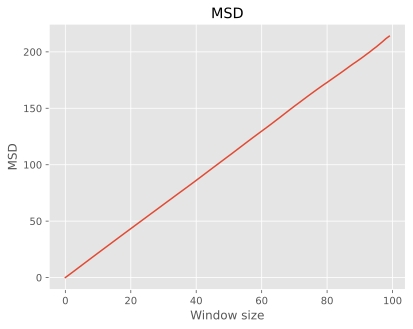

In [15]:
msd = freud.msd.MSD(box, mode="window")
msd.compute(positions)
msd.plot();